### Dataset creation ###

In [ ]:
import os
from sec_edgar_downloader import Downloader
import shutil
import time

def make_output_folder(folder_name):
    # Make sure output folder exists and create if not
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

# Download 10-K filings for each ticker using the SEC downloader
def download_filings(downloader, tickers, limit=7):
    for ticker in tickers:
        try:
            downloader.get("10-K", ticker, limit=limit)
            print(f"{ticker}: Downloaded.")
            time.sleep(1)
        except Exception as e:
            print(f"{ticker}: Failed to download. Error: {e}")

# Find downloaded filings and rename them into a cleaner format
def collect_and_rename_files(tickers, output_folder):
    # Search through downloaded folder structure to collect and rename 10-K filings
    for ticker in tickers:
        base = os.path.join("sec-edgar-filings", ticker, "10-K")
        if not os.path.exists(base):
            print(f"{ticker}: Folder missing.")
            continue

        for accession in sorted(os.listdir(base)):
            source = os.path.join(base, accession, "full-submission.txt")
            if not os.path.exists(source):
                print(f"{ticker}: Missing file {accession}")
                continue

            # Try to get year from accession number
            parts = accession.split("-")
            year = f"20{parts[1]}" if len(parts) > 1 else "unknown"

            # Rename the file to a readable format
            filename = f"10K_{ticker}_{year}.txt"
            shutil.copy(source, os.path.join(output_folder, filename))
            print(f"{ticker}: Saved {filename}")

# Delete any files that are not from the target years
def filter_for_years():
    input_folder = "raw_10ks"
    # Filter files in the input folder for specific years
    years = ["2020", "2021", "2022", "2023", "2024"]
    # Delete files not in the specified years
    for filename in os.listdir(input_folder):
        if not any(year in filename for year in years):
            file_path = os.path.join(input_folder, filename)
            os.remove(file_path)
            print(f"Deleted {filename} as it does not match the specified years.")

def main():
    tickers = [
        # Tech
        "AAPL", "GOOGL", "MSFT", "NVDA", "ORCL",
        # Financials
        "BAC",  "GS", "JPM", "MS", "V",
        # Healthcare
        "ABBV", "JNJ", "LLY", "MRK", "UNH"
    ]

    output = make_output_folder("raw_10ks")
    
    dl = Downloader("Copenhagen Business School", "daur24ac@student.cbs.dk")

    download_filings(dl, tickers)
    collect_and_rename_files(tickers, output)
    filter_for_years()

if __name__ == "__main__":
    main()


AAPL: Downloaded.
GOOGL: Downloaded.
MSFT: Downloaded.
NVDA: Downloaded.
ORCL: Downloaded.
BAC: Downloaded.
GS: Downloaded.
JPM: Downloaded.
MS: Downloaded.
V: Downloaded.
ABBV: Downloaded.
JNJ: Downloaded.
LLY: Downloaded.
MRK: Downloaded.
UNH: Downloaded.
AAPL: Saved 10K_AAPL_2018.txt
AAPL: Saved 10K_AAPL_2019.txt
AAPL: Saved 10K_AAPL_2020.txt
AAPL: Saved 10K_AAPL_2021.txt
AAPL: Saved 10K_AAPL_2022.txt
AAPL: Saved 10K_AAPL_2023.txt
AAPL: Saved 10K_AAPL_2024.txt
GOOGL: Saved 10K_GOOGL_2019.txt
GOOGL: Saved 10K_GOOGL_2020.txt
GOOGL: Saved 10K_GOOGL_2021.txt
GOOGL: Saved 10K_GOOGL_2022.txt
GOOGL: Saved 10K_GOOGL_2023.txt
GOOGL: Saved 10K_GOOGL_2024.txt
GOOGL: Saved 10K_GOOGL_2025.txt
MSFT: Saved 10K_MSFT_2023.txt
MSFT: Saved 10K_MSFT_2024.txt
MSFT: Saved 10K_MSFT_2018.txt
MSFT: Saved 10K_MSFT_2019.txt
MSFT: Saved 10K_MSFT_2020.txt
MSFT: Saved 10K_MSFT_2021.txt
MSFT: Saved 10K_MSFT_2022.txt
NVDA: Saved 10K_NVDA_2019.txt
NVDA: Saved 10K_NVDA_2020.txt
NVDA: Saved 10K_NVDA_2021.txt
NVDA: Sa

In [ ]:
from bs4 import BeautifulSoup
import datetime
import json
import re
import unicodedata

# Extracts relevant links from the table of contents based on known section names
def get_clean_toc_links(soup, max_links=50):
    VALID_CHAPTERS = [
        "business", "risk factors", "unresolved staff comments", "cybersecurity", "properties",
        "legal proceedings", "mine safety disclosures", "market for the registrant’s common stock",
        "management’s discussion and analysis", "quantitative and qualitative disclosures",
        "financial statements", "changes in and disagreements", "controls and procedures",
        "other information", "directors", "executive compensation", "security ownership",
        "certain relationships", "principal accountant fees", "exhibits", "form 10-k summary", "signatures"
    ]
    links = []
    for a in soup.find_all("a", href=True)[:max_links]:
        text = a.get_text(strip=True).lower()
        href = a["href"].strip().lstrip("#")
        # Only keep links that match known section names
        if any(valid in text for valid in VALID_CHAPTERS):
            links.append((text, href))
    return links

# Extracts the filing date from the text content
def extract_and_parse_filed_as_of_date(text_content, date_format="%Y%m%d"):
    match = re.search(r"FILED AS OF DATE:\s*(\d{8})", text_content, re.IGNORECASE)

    if match:
        date_str = match.group(1)
        try:
            return datetime.datetime.strptime(date_str, date_format)
        except ValueError:
            print(f"Error: Could not parse extracted date string: '{date_str}' with format '{date_format}'")
            return None
    else:
        return None

# Returns the last HTML tag with a given ID (sometimes IDs appear more than once)
def find_last_tag_by_id(soup, anchor_id):
    matches = soup.find_all(id=anchor_id)
    return matches[-1] if matches else None

# Extracts only the readable content between two HTML tags, skipping irrelevant tags
def extract_visible_section_text(soup, start_tag, stop_tag=None):
    buffer = []
    for tag in start_tag.find_all_next():
        if stop_tag and tag == stop_tag:
            break
        # Skip tags that don't contain meaningful content
        if tag.name in ["script", "style", "head", "footer", "nav", "table", "form"]:
            continue
        # Collect text from content tags
        if tag.name in ["div", "span", "section", "article", "p", "li"]:
            text = tag.get_text(strip=True, separator=" ")
            if text:
                buffer.append(text)
    return "\n\n".join(buffer).strip()

# Normalizes paragraph text to help identify duplicates
def normalize_paragraph(p):
    p = unicodedata.normalize("NFKC", p)
    p = p.strip().lower()
    p = re.sub(r"[ \xa0\t]+", " ", p)
    p = re.sub(r"[®™†*]+", "", p)
    p = re.sub(r"[^\w\s]", "", p)
    return p

# Removes duplicate paragraphs from a section
def remove_duplicate_paragraphs(text):
    paragraphs = text.split("\n\n")
    seen = set()
    unique = []
    for p in paragraphs:
        norm = normalize_paragraph(p)
        if norm and norm not in seen:
            seen.add(norm)
            unique.append(p.strip())
    return "\n\n".join(unique).strip()

# Main function that processes one 10-K file and extracts its cleaned sections
def process_10k_file(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        html = f.read()

    soup = BeautifulSoup(html, "lxml")
    toc_links = get_clean_toc_links(soup)

    doc_sections = {}
    for i, (label, anchor_id) in enumerate(toc_links):
        start_tag = find_last_tag_by_id(soup, anchor_id)
        if not start_tag:
            continue
        stop_tag = find_last_tag_by_id(soup, toc_links[i + 1][1]) if i + 1 < len(toc_links) else None
        raw = extract_visible_section_text(soup, start_tag, stop_tag)
        clean = remove_duplicate_paragraphs(raw)
        doc_sections[label.lower()] = clean

    return doc_sections

# Set input and output folders
INPUT_FOLDER = "raw_10ks"
OUTPUT_FOLDER = "processed_10ks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Loop over all raw 10-K files and process them
date_releases = {}
for filename in sorted(os.listdir(INPUT_FOLDER)):
    if not filename.endswith(".txt"):
        continue

    input_path = os.path.join(INPUT_FOLDER, filename)
    output_path = os.path.join(OUTPUT_FOLDER, filename.replace(".txt", ".json"))

    print(f"Processing {filename}...")
    # Extract the filing date and store it
    date_releases[filename] = extract_and_parse_filed_as_of_date(open(input_path, "r").read())
    # Process file and extract cleaned sections
    cleaned_sections = process_10k_file(input_path)

    # Save cleaned data to JSON
    with open(output_path, "w", encoding="utf-8") as out:
        json.dump(cleaned_sections, out, indent=2)

print("All files processed and saved.")


Processing 10K_AAPL_2020.txt...
Processing 10K_AAPL_2021.txt...
Processing 10K_AAPL_2022.txt...
Processing 10K_AAPL_2023.txt...
Processing 10K_AAPL_2024.txt...
Processing 10K_ABBV_2020.txt...
Processing 10K_ABBV_2021.txt...
Processing 10K_ABBV_2022.txt...
Processing 10K_ABBV_2023.txt...
Processing 10K_ABBV_2024.txt...
Processing 10K_BAC_2020.txt...
Processing 10K_BAC_2021.txt...
Processing 10K_BAC_2022.txt...
Processing 10K_BAC_2023.txt...
Processing 10K_BAC_2024.txt...
Processing 10K_GOOGL_2020.txt...
Processing 10K_GOOGL_2021.txt...
Processing 10K_GOOGL_2022.txt...
Processing 10K_GOOGL_2023.txt...
Processing 10K_GOOGL_2024.txt...
Processing 10K_GS_2020.txt...
Processing 10K_GS_2021.txt...
Processing 10K_GS_2022.txt...
Processing 10K_GS_2023.txt...
Processing 10K_GS_2024.txt...
Processing 10K_JNJ_2020.txt...
Processing 10K_JNJ_2021.txt...
Processing 10K_JNJ_2022.txt...
Processing 10K_JNJ_2023.txt...
Processing 10K_JNJ_2024.txt...
Processing 10K_JPM_2020.txt...
Processing 10K_JPM_2021.

### Topic Modeling ###

In [ ]:
from bertopic import BERTopic
import json
import pandas as pd
from sentence_transformers import SentenceTransformer
from umap import UMAP

# Set up constants for section key, output file, and firm-to-industry mapping
SECTION_KEY = "risk factors"
OUTPUT_TOPICS = "risk_topics.csv"
INDUSTRY_MAP = {
    "ABBV": "Healthcare", "AAPL": "Technology", "BAC": "Financials",
    "GOOGL": "Technology", "GS": "Financials", "JNJ": "Healthcare",
    "JPM": "Financials", "LLY": "Healthcare", "MRK": "Healthcare",
    "MS": "Financials", "MSFT": "Technology", "NVDA": "Technology",
    "ORCL": "Technology", "UNH": "Healthcare", "V": "Financials"
}

# Extracts clean paragraphs from 10-K text
def extract_paragraphs(text, min_words=5):
    paragraphs = text.split("\n\n")
    cleaned = []
    for p in paragraphs:
        p = p.strip()
        # Skip short paragraphs
        if len(p.split()) < min_words:
            continue
        # Filter out common section titles and boilerplate text
        if re.search(r"Form\s+10-K|\bItem\b|\bTable of Contents\b|\d{4}|\bRisk Factors\b", p, re.IGNORECASE):
            if len(p.split()) < 10:
                continue
        cleaned.append(p)
    return cleaned

# Loads JSON files and extracts relevant paragraphs from the chosen section
def load_clean_paragraphs(folder, section_key, industry_map):
    rows = []
    print("Loading and cleaning paragraphs...")
    for filename in os.listdir(folder):
        if not filename.endswith(".json"):
            continue
        # Parse firm and year from filename
        parts = filename.replace(".json", "").split("_")
        if len(parts) < 3:
            continue
        firm, year = parts[1], parts[2]
        industry = industry_map.get(firm)
        if not industry:
            continue
        # Load JSON file and extract section text
        with open(os.path.join(folder, filename), "r", encoding="utf-8") as f:
            data = json.load(f)
        section_text = data.get(section_key, "")
        if section_text:
            # Extract clean paragraphs from the section
            for p in extract_paragraphs(section_text):
                rows.append({
                    "firm": firm,
                    "year": int(year),
                    "industry": industry,
                    "text": p.strip()
                })
    print(f"Extracted {len(rows)} clean paragraphs.")
    return pd.DataFrame(rows)

# Runs BERTopic to assign topic labels to the text
def topic_model(input_df, top_n_keywords=3):
    print("Running BERTopic on", len(input_df), "paragraphs...")
    # Set up embedding and dimensionality reduction models
    embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
    umap_model = UMAP(random_state=42)

    # Create and fit BERTopic model
    model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        calculate_probabilities=False,
        verbose=True
    )

    topics, _ = model.fit_transform(input_df["text"].tolist())
    input_df["topic"] = topics

    # Get short labels for each topic using top keywords
    topic_labels = {
        topic: ", ".join([kw for kw, _ in model.get_topic(topic)[:top_n_keywords]])
        if topic != -1 else "Other"
        for topic in model.get_topic_freq().Topic
    }

    # Add topic labels to the dataframe
    input_df["topic_label"] = input_df["topic"].map(topic_labels)

    # Save topics to CSV
    input_df.to_csv(OUTPUT_TOPICS, index=False)
    print("Saved:", OUTPUT_TOPICS)
    return input_df, topic_labels

def main():
    df = load_clean_paragraphs(OUTPUT_FOLDER, SECTION_KEY, INDUSTRY_MAP)
    # Remove duplicate rows based on firm, year, and text
    df = df.drop_duplicates(subset=["firm", "year", "text"])
    print("Paragraphs cleaned and ready for topic modeling.")
    df_with_topics, topic_labels = topic_model(df)
    return df_with_topics, topic_labels

df_with_topics, topic_labels = main()


Loading and cleaning paragraphs...
Extracted 11895 clean paragraphs.
Paragraphs cleaned and ready for topic modeling.
Running BERTopic on 11895 paragraphs...


2025-05-29 16:50:31,454 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/372 [00:00<?, ?it/s]

2025-05-29 16:50:50,751 - BERTopic - Embedding - Completed ✓
2025-05-29 16:50:50,753 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-29 16:50:57,571 - BERTopic - Dimensionality - Completed ✓
2025-05-29 16:50:57,576 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-29 16:50:57,779 - BERTopic - Cluster - Completed ✓
2025-05-29 16:50:57,793 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-29 16:50:58,255 - BERTopic - Representation - Completed ✓


Saved: risk_topics.csv


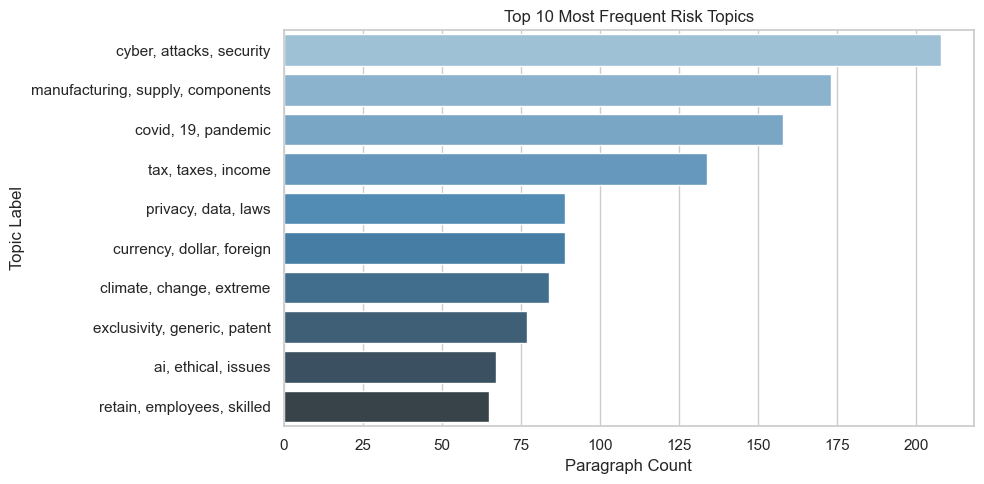

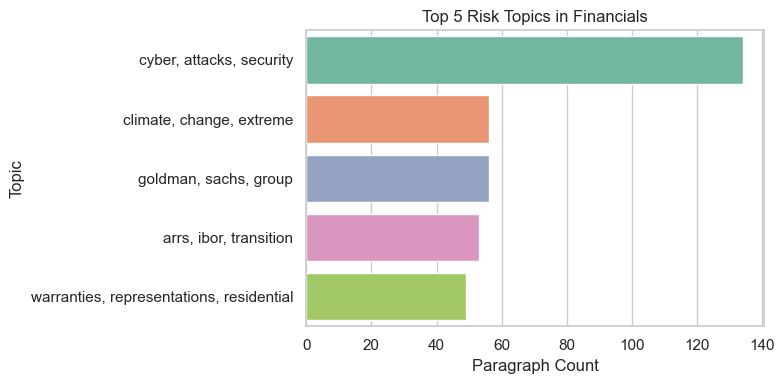

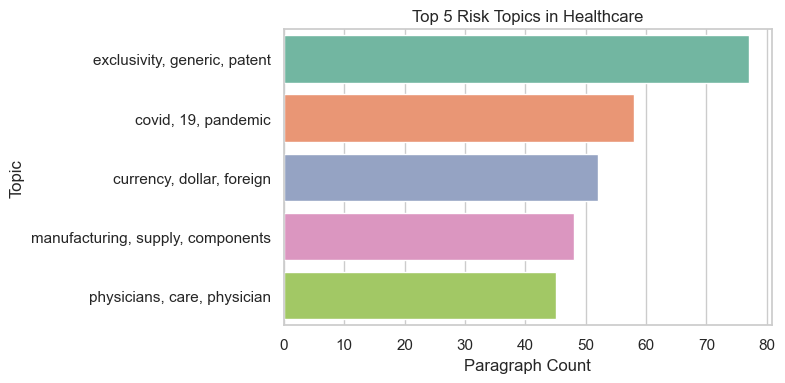

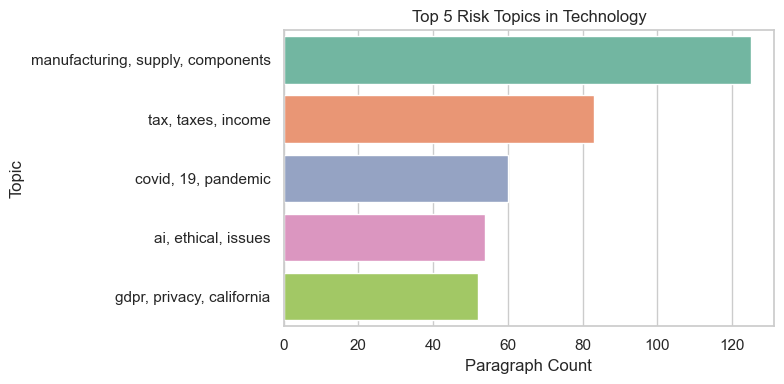

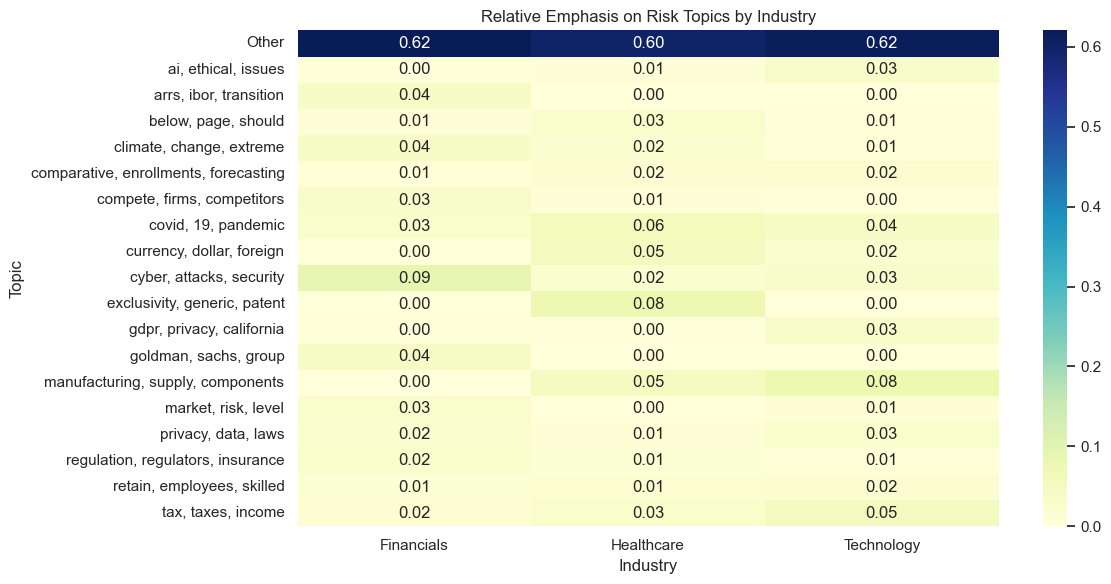

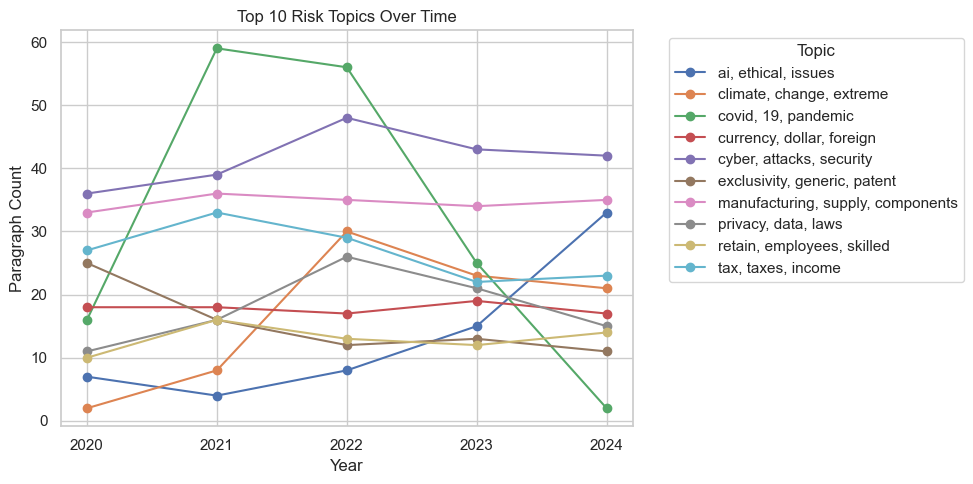

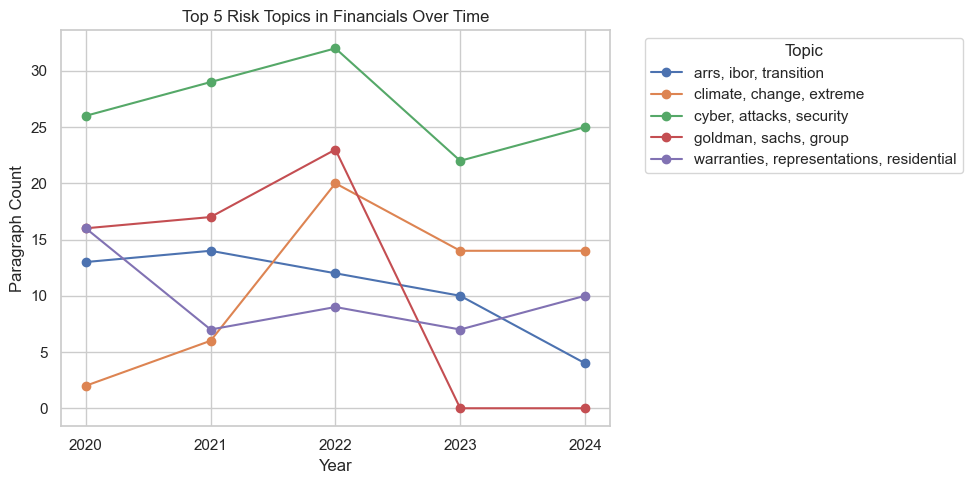

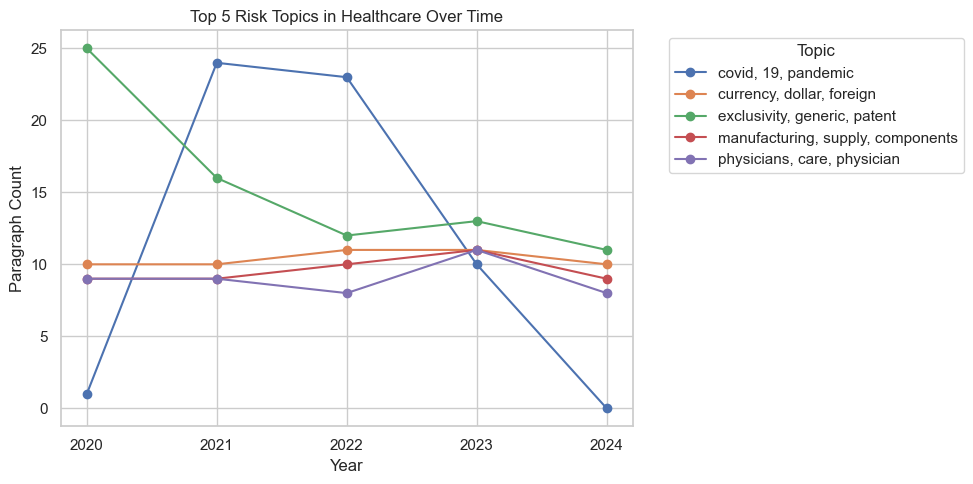

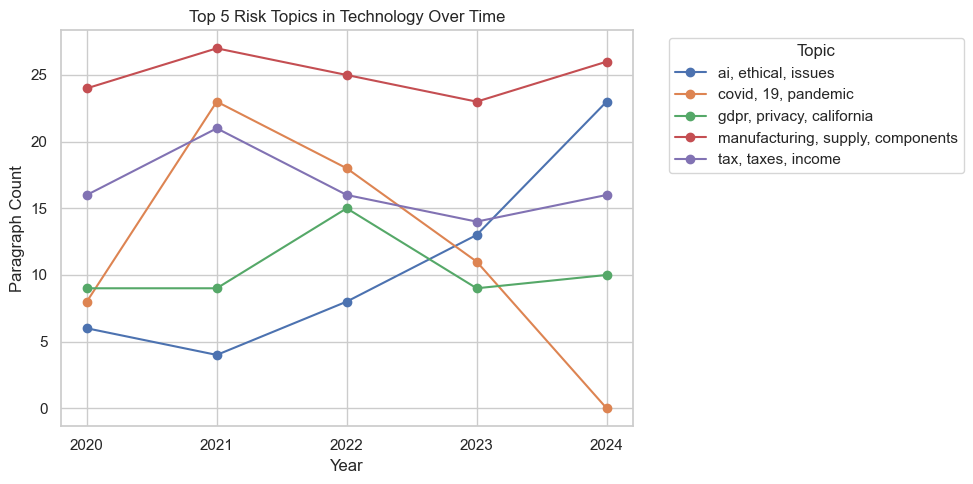

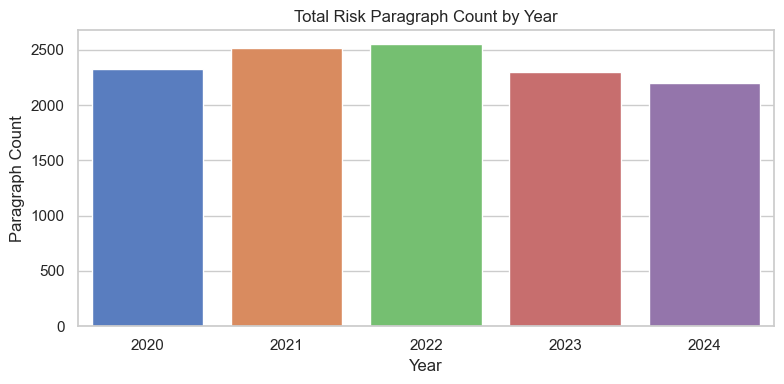

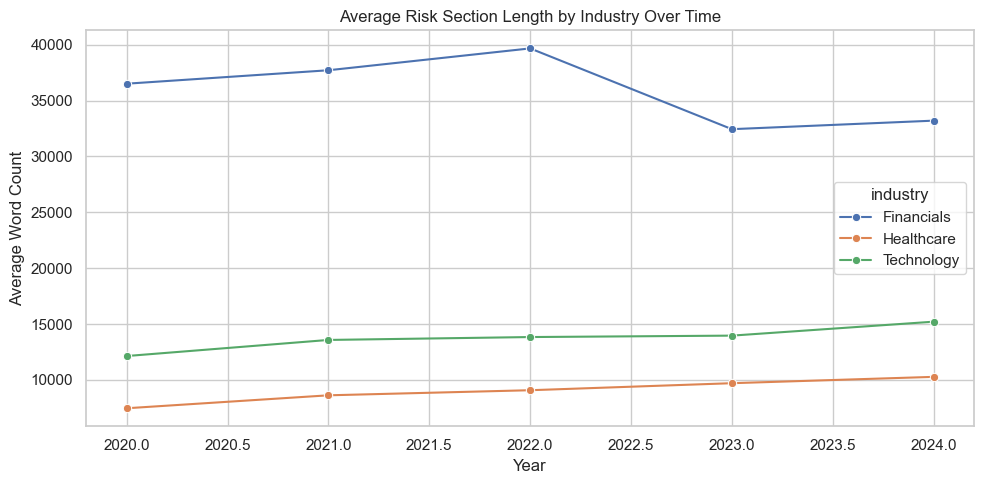

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")  # Set plot style

# Finds the most frequent topics overall and saves to CSV
def find_top_topics(df, top_n=10):
    df = df[df["topic_label"] != "Other"]
    top_overall = (
        df["topic_label"]
        .value_counts()
        .head(top_n)
        .reset_index()
        .rename(columns={"index": "topic_label", "topic_label": "count"})
    )
    top_overall.to_csv("top_topics_total.csv", index=False)

# Plots a bar chart of the most frequent topics across all industries
def plot_top_overall(df, top_n=10):
    df = df[df["topic_label"] != "Other"]
    top_topics = df["topic_label"].value_counts().head(top_n)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_topics.values, y=top_topics.index, palette="Blues_d")
    plt.xlabel("Paragraph Count")
    plt.ylabel("Topic Label")
    plt.title(f"Top {top_n} Most Frequent Risk Topics")
    plt.tight_layout()
    plt.savefig("top_10_most_frequent_risk_topics.png")
    plt.show()
    plt.close()

# Calculates and plots the top risk topics for each industry separately
def top_topics_per_industry(df, top_n=5):
    df = df[df["topic_label"] != "Other"]
    grouped = (
        df.groupby(["industry", "topic_label"])
        .size()
        .reset_index(name="count")
        .sort_values(["industry", "count"], ascending=[True, False])
    )
    top_per_industry = grouped.groupby("industry").head(top_n)
    top_per_industry.to_csv("top_topics_per_industry.csv", index=False)

    # Create a separate bar chart for each industry
    for industry, filename in zip(
        ["Financials", "Healthcare", "Technology"],
        [
            "top_5_risk_topics_financials.png",
            "top_5_risk_topics_healthcare.png",
            "top_5_risk_topics_technology.png"
        ]
    ):
        subset = top_per_industry[top_per_industry["industry"] == industry]
        if not subset.empty:
            plt.figure(figsize=(8, 4))
            sns.barplot(x="count", y="topic_label", data=subset, palette="Set2")
            plt.xlabel("Paragraph Count")
            plt.ylabel("Topic")
            plt.title(f"Top {top_n} Risk Topics in {industry}")
            plt.tight_layout()
            plt.savefig(filename)
            plt.show()
            plt.close()

# Creates a heatmap showing how much each industry focuses on each topic
def plot_industry_risk_profile(df, min_topic_count=50):
    counts = df.groupby(["industry", "topic_label"]).size().unstack(fill_value=0)
    counts = counts.loc[:, counts.sum() > min_topic_count]  # Filter by topic frequency
    counts_norm = counts.div(counts.sum(axis=1), axis=0)  # Normalize by industry
    plt.figure(figsize=(12, 6))
    sns.heatmap(counts_norm.T, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.xlabel("Industry")
    plt.ylabel("Topic")
    plt.title("Relative Emphasis on Risk Topics by Industry")
    plt.tight_layout()
    plt.savefig("relative_emphasis_on_risk_topics.png")
    plt.show()
    plt.close()

# Plots the top risk topics over time across all industries
def plot_topic_trends_over_time(df, top_n=10):
    df = df[df["topic_label"] != "Other"]
    top_labels = df["topic_label"].value_counts().head(top_n).index
    df_top = df[df["topic_label"].isin(top_labels)]
    pivot = df_top.groupby(["year", "topic_label"]).size().unstack(fill_value=0)
    ax = pivot.plot(kind="line", marker="o", figsize=(10, 5))
    ax.set_xticks(sorted(df["year"].unique()))
    ax.set_xticklabels(sorted(df["year"].unique()), rotation=0)
    plt.xlabel("Year")
    plt.ylabel("Paragraph Count")
    plt.title(f"Top {top_n} Risk Topics Over Time")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("top_10_risk_topics_over_time.png")
    plt.show()
    plt.close()

# Plots top risk topics over time separately for each industry
def plot_topic_trends_by_industry(df, top_n=5):
    df = df[df["topic_label"] != "Other"]
    for industry, filename in zip(
        ["Financials", "Healthcare", "Technology"],
        [
            "top_5_risk_topics_over_time_financials.png",
            "top_5_risk_topics_over_time_healthcare.png",
            "top_5_risk_topics_over_time_technology.png"
        ]
    ):
        df_ind = df[df["industry"] == industry]
        top_labels = df_ind["topic_label"].value_counts().head(top_n).index
        df_top = df_ind[df_ind["topic_label"].isin(top_labels)]
        pivot = df_top.groupby(["year", "topic_label"]).size().unstack(fill_value=0)
        ax = pivot.plot(kind="line", marker="o", figsize=(10, 5), title=f"{industry} – Top {top_n} Topics Over Time")
        ax.set_xticks(sorted(df["year"].unique()))
        ax.set_xticklabels(sorted(df["year"].unique()), rotation=0)
        plt.xlabel("Year")
        plt.ylabel("Paragraph Count")
        plt.title(f"Top {top_n} Risk Topics in {industry} Over Time")
        plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        plt.close()

# Plots how many risk-related paragraphs exist for each year
def plot_total_paragraph_volume(df):
    yearly_counts = df.groupby("year").size().reset_index(name="paragraph_count")
    plt.figure(figsize=(8, 4))
    sns.barplot(x="year", y="paragraph_count", data=yearly_counts, palette="muted")
    plt.xlabel("Year")
    plt.ylabel("Paragraph Count")
    plt.title("Total Risk Paragraph Count by Year")
    plt.tight_layout()
    plt.savefig("risk_paragraph_count.png")
    plt.show()
    plt.close()

# Plots average word count of risk sections by industry over time
def plot_risk_section_length(df):
    df["word_count"] = df["text"].str.split().str.len()
    lengths = df.groupby(["firm", "year", "industry"])["word_count"].sum().reset_index()
    avg_by_industry = lengths.groupby(["industry", "year"])["word_count"].mean().reset_index()

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=avg_by_industry, x="year", y="word_count", hue="industry", marker="o")
    plt.xlabel("Year")
    plt.ylabel("Average Word Count")
    plt.title("Average Risk Section Length by Industry Over Time")
    plt.tight_layout()
    plt.savefig("risk_section_length.png")
    plt.show()
    plt.close()

if __name__ == "__main__":
    find_top_topics(df_with_topics)
    plot_top_overall(df_with_topics)
    top_topics_per_industry(df_with_topics)
    plot_industry_risk_profile(df_with_topics)
    plot_topic_trends_over_time(df_with_topics, top_n=10)
    plot_topic_trends_by_industry(df_with_topics, top_n=5)
    plot_total_paragraph_volume(df_with_topics)
    plot_risk_section_length(df_with_topics)


In [ ]:
# Lists companies with the longest risk disclosures based on word count
def list_top_risk_disclosures(df, top_n=10):
    # Calculate word count per paragraph
    df["word_count"] = df["text"].str.split().str.len()
    # Sum word counts for each firm-year combination
    totals = df.groupby(["firm", "year", "industry"])["word_count"].sum().reset_index()
    # Sort and return the top N longest disclosures
    top_longest = totals.sort_values("word_count", ascending=False).head(top_n)
    return top_longest

print("Top companies by total risk disclosure length:")
list_top_risk_disclosures(df_with_topics, top_n=15)


Top companies by total risk disclosure length:


,firm,year,industry,word_count
22,GS,2022,Financials,58711
21,GS,2021,Financials,57238
12,BAC,2022,Financials,54683
14,BAC,2024,Financials,50805
20,GS,2020,Financials,50439
13,BAC,2023,Financials,50249
10,BAC,2020,Financials,49608
11,BAC,2021,Financials,49045
41,MS,2024,Financials,33242
37,MS,2020,Financials,32938


### Financial Performance Data ###

In [ ]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import yfinance as yf

# Output file for saving stock performance results
OUTPUT_FILE = "stock_performance_analysis.csv"
# Max number of days to wait to find a valid price
PRICE_DATE_WINDOW_DAYS = 7
# Number of days to track stock performance after release
PERFORMANCE_PERIOD_DAYS = 15
# Delay between requests to avoid hitting API limits
REQUEST_DELAY_SECONDS = 1.5

def get_price_on_or_after(ticker, target_date, window_days):
    """Fetches the first available closing price on or after a target date."""
    try:
        time.sleep(REQUEST_DELAY_SECONDS)
        data = yf.download(
            ticker,
            start=target_date,
            end=target_date + timedelta(days=window_days),
            progress=False,
            auto_adjust=True
        )
        if not data.empty:
            price_info = data.iloc[0]
            return float(price_info["Close"]), price_info.name.to_pydatetime()
        return None, None
    except Exception as e:
        print(f"yfinance API error for {ticker} near {target_date.strftime('%Y-%m-%d')}: {e}")
        return None, None

def calculate_stock_performance(ticker, release_date):
    """Analyzes stock performance for a single ticker given a release date."""
    # Get start price after release date
    start_price, start_date = get_price_on_or_after(ticker, release_date, PRICE_DATE_WINDOW_DAYS)
    if not start_price:
        return {"error": "No data near start date"}

    # Get end price a set number of days later
    target_end_date = release_date + relativedelta(days=PERFORMANCE_PERIOD_DAYS)
    end_price, end_date = get_price_on_or_after(ticker, target_end_date, PRICE_DATE_WINDOW_DAYS)
    if not end_price:
        return {"error": "No data near end date", "start_price": start_price, "start_date": start_date}

    # Calculate price and percentage change
    price_change = end_price - start_price
    percentage_change = (price_change / start_price) * 100 if start_price != 0 else 0

    return {
        "release_date": release_date.strftime("%Y-%m-%d"),
        "start_price_date": start_date.strftime("%Y-%m-%d"),
        "start_price": round(start_price, 2),
        "actual_end_price_date": end_date.strftime("%Y-%m-%d"),
        "end_price": round(end_price, 2),
        "price_change": round(price_change, 2),
        "percentage_change": round(percentage_change, 2),
        "rose": price_change > 0
    }

def process_all_releases(date_releases):
    """Processes a dictionary of filenames and release dates to analyze stock performance."""
    results_list = []
    print(f"Processing {len(date_releases)} files for stock performance...")

    for filename, release_date in date_releases.items():
        try:
            # Get ticker from filename
            ticker = filename.split("_")[1]

            # Run performance analysis for this ticker and date
            analysis_result = calculate_stock_performance(ticker, release_date)
            analysis_result["filename"] = filename.replace(".txt", ".json")
            analysis_result["ticker"] = ticker
            results_list.append(analysis_result)

        except IndexError as e:
            # Handle filenames that do not follow the expected format
            print(f'Error processing "{filename}": Could not extract ticker. Skipping.')
            results_list.append({"filename": filename, "error": f"Could not parse ticker: {e}"})

    return results_list

def save_results(results_list, output_path):
    """Saves the list of analysis results to a CSV file."""
    if not results_list:
        print("No results to save.")
        return

    results_df = pd.DataFrame(results_list)
    results_df.to_csv(output_path, index=False)
    print(f"Analysis complete. Results saved to {output_path}.")
    print(results_df.head().to_string())

def main():
    """Main function to orchestrate the stock performance analysis."""
    results_list = process_all_releases(date_releases)
    save_results(results_list, OUTPUT_FILE)

if __name__ == "__main__":
    main()


Processing 75 files for stock performance...
Analyzing AAPL from 10K_AAPL_2020.txt...
Analyzing AAPL from 10K_AAPL_2021.txt...
Analyzing AAPL from 10K_AAPL_2022.txt...
Analyzing AAPL from 10K_AAPL_2023.txt...
Analyzing AAPL from 10K_AAPL_2024.txt...
Analyzing ABBV from 10K_ABBV_2020.txt...
Analyzing ABBV from 10K_ABBV_2021.txt...
Analyzing ABBV from 10K_ABBV_2022.txt...
Analyzing ABBV from 10K_ABBV_2023.txt...
Analyzing ABBV from 10K_ABBV_2024.txt...
Analyzing BAC from 10K_BAC_2020.txt...
Analyzing BAC from 10K_BAC_2021.txt...
Analyzing BAC from 10K_BAC_2022.txt...
Analyzing BAC from 10K_BAC_2023.txt...
Analyzing BAC from 10K_BAC_2024.txt...
Analyzing GOOGL from 10K_GOOGL_2020.txt...
Analyzing GOOGL from 10K_GOOGL_2021.txt...
Analyzing GOOGL from 10K_GOOGL_2022.txt...
Analyzing GOOGL from 10K_GOOGL_2023.txt...
Analyzing GOOGL from 10K_GOOGL_2024.txt...
Analyzing GS from 10K_GS_2020.txt...
Analyzing GS from 10K_GS_2021.txt...
Analyzing GS from 10K_GS_2022.txt...
Analyzing GS from 10K_GS

### Sentiment Analysis ###

***Dictionary-based sentiment***

In [ ]:
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

le = WordNetLemmatizer()

# Prepares text for sentiment analysis by tokenizing, filtering, and lemmatizing
def preprocess_text_for_lm(text):
    if not text:
        return []
    # Convert to lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Keep only alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Lemmatize words
    tokens = [le.lemmatize(word) for word in tokens]
    return tokens

# Counts how many tokens match words in each sentiment lexicon
def get_lm_sentiment_counts(tokens, negative_lex, positive_lex, uncertainty_lex):
    counts = defaultdict(int)
    token_counts = Counter(tokens)
    for word, count in token_counts.items():
        if word in negative_lex:
            counts["negative"] += count
        if word in positive_lex:
            counts["positive"] += count
        if word in uncertainty_lex:
            counts["uncertainty"] += count
    return counts

# Applies Loughran-McDonald sentiment analysis to a text
def analyze_lm_sentiment(text, lexicons):
    # Preprocess the text and get cleaned tokens
    processed_tokens = preprocess_text_for_lm(text)
    total_words = len(processed_tokens)
    
    # Return default values if there are no words to analyze
    if total_words == 0:
        return {
            "lm_score": 0, "lm_total_words": 0,
            "lm_negative_words": 0, "lm_positive_words": 0, "lm_uncertainty_words": 0
        }

    # Count matches from the lexicons
    counts = get_lm_sentiment_counts(processed_tokens, **lexicons)

    # Calculate sentiment score (negative + uncertainty - positive)
    lm_score = (counts["negative"] + counts["uncertainty"] - counts["positive"])

    # Return detailed sentiment breakdown
    return {
        "lm_score": lm_score,
        "lm_total_words": total_words,
        "lm_negative_words": counts["negative"],
        "lm_positive_words": counts["positive"],
        "lm_uncertainty_words": counts["uncertainty"],
        "lm_neg_percent": round((counts["negative"] / total_words) * 100, 2) if total_words > 0 else 0,
        "lm_pos_percent": round((counts["positive"] / total_words) * 100, 2) if total_words > 0 else 0,
        "lm_unc_percent": round((counts["uncertainty"] / total_words) * 100, 2) if total_words > 0 else 0,
    }


***FinBERT Sentiment***

In [ ]:
def create_text_chunks(text, tokenizer, chunk_size=400, overlap=100):
    """
    Splits a long text into overlapping chunks based on tokens.
    """
    # Tokenize the text without adding special tokens
    tokens = tokenizer.encode(text, add_special_tokens=False)

    chunk_token_ids = []
    # Slide a window over tokens with defined overlap
    for i in range(0, len(tokens), chunk_size - overlap):
        chunk = tokens[i : i + chunk_size]
        if chunk:
            chunk_token_ids.append(chunk)

    # Convert token chunks back to text
    text_chunks = [tokenizer.decode(chunk) for chunk in chunk_token_ids]
    return text_chunks

def aggregate_pipeline_results(pipeline_outputs, model_config):
    """
    Aggregates the list of results from a transformers pipeline.
    """
    # Handle case where no chunks were analyzed
    if not pipeline_outputs:
        return {"aggregated_label": "NOT_ENOUGH_TEXT", "avg_probabilities": {}, "chunk_count": 0}

    prob_sums = defaultdict(float)
    chunk_count = len(pipeline_outputs)

    # Sum up probabilities for each label across all chunks
    for result_group in pipeline_outputs:
        for result in result_group:
            label = result["label"].lower()
            prob_sums[label] += result["score"]

    # Average the probabilities by number of chunks
    avg_probs = {label: total / chunk_count for label, total in prob_sums.items()}

    # Ensure all expected labels are present (even if they had zero probability)
    for label_id in model_config.id2label.values():
        label_lower = label_id.lower()
        if label_lower not in avg_probs:
            avg_probs[label_lower] = 0.0

    # Choose the label with the highest average probability
    if not avg_probs:
        aggregated_label = "Error"
    else:
        aggregated_label = max(avg_probs, key=avg_probs.get).capitalize()

    return {
        "aggregated_label": aggregated_label,
        "avg_probabilities": {
            "positive": round(avg_probs.get("positive", 0.0), 4),
            "negative": round(avg_probs.get("negative", 0.0), 4),
            "neutral": round(avg_probs.get("neutral", 0.0), 4)
        },
        "chunk_count": chunk_count
    }


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Define file paths and constants
STATEMENTS_FOLDER = "processed_10ks"
LM_DICTIONARY_FILE = "Loughran-McDonald_MasterDictionary_1993-2024.csv"
FINANCIAL_RESULTS_FILE = "stock_performance_analysis.csv"
OUTPUT_FILENAME = "combined_sentiment_analysis_pipeline.csv"
MODEL_NAME = "yiyanghkust/finbert-tone"
SECTION_KEY = "management’s discussion"

def load_lm_dictionary(filepath):
    """Loads and prepares the Loughran-McDonald sentiment lexicons."""
    print(f"Loading LM Dictionary from {filepath}...")
    lm_dict_df = pd.read_csv(filepath)
    lexicons = {
        "negative_lex": set(lm_dict_df[lm_dict_df["Negative"] != 0]["Word"].str.lower()),
        "positive_lex": set(lm_dict_df[lm_dict_df["Positive"] != 0]["Word"].str.lower()),
        "uncertainty_lex": set(lm_dict_df[lm_dict_df["Uncertainty"] != 0]["Word"].str.lower())
    }
    return lexicons

def load_finbert_pipeline(model_name):
    """Initializes the FinBERT model, tokenizer, and sentiment analysis pipeline."""
    print(f"Initializing FinBERT model ({model_name})...")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, top_k=None)
    print("Pipeline Initialized and Ready.")
    return sentiment_pipeline, tokenizer

def process_files_for_analysis(folder_path, section_key, lexicons, tokenizer):
    """
    Reads all JSON files, performs LM analysis, and creates text chunks for FinBERT.
    Returns the initial results, all text chunks, and the mapping of chunks to files.
    """
    print("Reading all files and creating text chunks...")
    all_results, all_text_chunks, chunk_to_file_map = [], [], []

    for filename in tqdm(sorted(os.listdir(folder_path)), desc="Processing files"):
        if not filename.lower().endswith(".json"):
            continue

        full_path = os.path.join(folder_path, filename)
        with open(full_path, "r", encoding="utf-8", errors="ignore") as f:
            current_file = json.load(f)

        for chapter, text in current_file.items():
            # Only analyze matching sections with enough text
            if section_key not in chapter.lower() or not isinstance(text, str) or len(text) < 200:
                continue

            # Extract ticker from file or fallback
            ticker = current_file.get("ticker", filename.split("_")[1] if "_" in filename else "N/A")
            record = {
                "filename": filename, "chapter": chapter, "ticker": ticker,
                "industry": INDUSTRY_MAP.get(ticker)
            }
            # Run LM sentiment analysis
            record.update(analyze_lm_sentiment(text, lexicons))
            all_results.append(record)

            # Create text chunks for FinBERT
            text_chunks = create_text_chunks(text, tokenizer)
            if text_chunks:
                all_text_chunks.extend(text_chunks)
                chunk_to_file_map.extend([filename] * len(text_chunks))

    return all_results, all_text_chunks, chunk_to_file_map

def run_finbert_analysis(sentiment_pipeline, all_text_chunks):
    """
    Runs the FinBERT pipeline in batches.
    """
    print(f"Running FinBERT on {len(all_text_chunks)} text chunks...")
    if not all_text_chunks:
        print("No text chunks found to analyze with FinBERT.")
        return []

    batch_size = 32
    all_outputs = []

    for i in tqdm(range(0, len(all_text_chunks), batch_size), desc="FinBERT Analysis"):
        batch = all_text_chunks[i : i + batch_size]
        outputs = sentiment_pipeline(batch)
        all_outputs.extend(outputs)

    return all_outputs

def combine_analysis_results(all_results, pipeline_outputs, chunk_to_file_map, model_config):
    """
    Aggregates FinBERT chunk results and merges them with the LM analysis results.
    """
    print("Combining all analysis results...")
    if not pipeline_outputs:
        return all_results

    # Group FinBERT results by filename
    temp_file_results = defaultdict(list)
    for i, output_group in enumerate(pipeline_outputs):
        filename = chunk_to_file_map[i]
        temp_file_results[filename].append(output_group)

    # Aggregate FinBERT results per file
    finbert_outputs_aggregated = {}
    for filename, outputs in temp_file_results.items():
        finbert_outputs_aggregated[filename] = aggregate_pipeline_results(outputs, model_config)

    # Merge aggregated FinBERT scores into LM results
    for record in all_results:
        filename = record["filename"]
        chunking_results = finbert_outputs_aggregated.get(filename, {
            "aggregated_label": "NOT_ENOUGH_TEXT", "avg_probabilities": {}, "chunk_count": 0
        })
        finbert_results = {
            "finbert_label": chunking_results["aggregated_label"],
            "finbert_prob_positive": chunking_results["avg_probabilities"].get("positive"),
            "finbert_prob_negative": chunking_results["avg_probabilities"].get("negative"),
            "finbert_prob_neutral": chunking_results["avg_probabilities"].get("neutral"),
            "finbert_chunks": chunking_results["chunk_count"]
        }
        record.update(finbert_results)

    return all_results

def create_and_save_dataframe(final_results, financial_data_path, output_path):
    """Creates the final DataFrame, merges financial data, and saves it to a CSV file."""
    print("Creating and Saving Final DataFrame...")
    if not final_results:
        print("No results were generated. Exiting.")
        return

    results_df = pd.DataFrame(final_results)
    # Select columns to keep
    cols_order = [
        "filename", "ticker", "chapter", "finbert_label", "finbert_chunks", "lm_score",
        "finbert_prob_negative", "finbert_prob_positive", "finbert_prob_neutral",
        "lm_neg_percent", "lm_pos_percent", "lm_unc_percent", "lm_total_words"
    ]
    existing_cols = [col for col in cols_order if col in results_df.columns]
    results_df = results_df[existing_cols]

    # Optionally merge with financial data
    if os.path.exists(financial_data_path):
        print(f"Merging with financial data from {financial_data_path}...")
        fin_results_df = pd.read_csv(financial_data_path)
        results_df = results_df.merge(fin_results_df, how="left", on="filename")

    results_df.to_csv(output_path, index=False)
    print(f"Analysis Complete! Results saved to {output_path}.")
    print("Here are the first 5 rows:")
    print(results_df.head().to_string())

def main():
    """
    Main function to orchestrate the entire sentiment analysis pipeline.
    """
    lm_lexicons = load_lm_dictionary(LM_DICTIONARY_FILE)
    sentiment_pipeline, tokenizer = load_finbert_pipeline(MODEL_NAME)

    all_results, all_text_chunks, chunk_to_file_map = process_files_for_analysis(
        STATEMENTS_FOLDER, SECTION_KEY, lm_lexicons, tokenizer
    )

    pipeline_outputs = run_finbert_analysis(sentiment_pipeline, all_text_chunks)

    final_results = combine_analysis_results(
        all_results, pipeline_outputs, chunk_to_file_map, sentiment_pipeline.model.config
    )

    create_and_save_dataframe(final_results, FINANCIAL_RESULTS_FILE, OUTPUT_FILENAME)

if __name__ == "__main__":
    main()


Loading LM Dictionary from Loughran-McDonald_MasterDictionary_1993-2024.csv...
Initializing FinBERT model (yiyanghkust/finbert-tone)...


Device set to use mps


Pipeline Initialized and Ready.
Reading all files and creating text chunks...


Processing files: 100%|██████████| 75/75 [02:11<00:00,  1.76s/it]


Running FinBERT on 109306 text chunks...


FinBERT Analysis: 100%|██████████| 3416/3416 [2:08:00<00:00,  2.25s/it]  


Combining all analysis results...
Creating and Saving Final DataFrame...
Merging with financial data from stock_performance_analysis.csv...
Analysis Complete! Results saved to combined_sentiment_analysis_pipeline.csv.
Here are the first 5 rows:
             filename ticker_x                                                                                chapter finbert_label  finbert_chunks  lm_score  finbert_prob_negative  finbert_prob_positive  finbert_prob_neutral  lm_neg_percent  lm_pos_percent  lm_unc_percent  lm_total_words release_date start_price_date  start_price actual_end_price_date  end_price  price_change  percentage_change   rose ticker_y
0  10K_AAPL_2020.json     AAPL  management’s discussion and analysis of financial condition and results of operations       Neutral              26        98                 0.0799                 0.0060                0.9142            1.34            0.48            1.19            4784   2020-10-30       2020-10-30       106.01        

***Correlation between sentiment and financial performance***

Generating Correlation Heatmap...


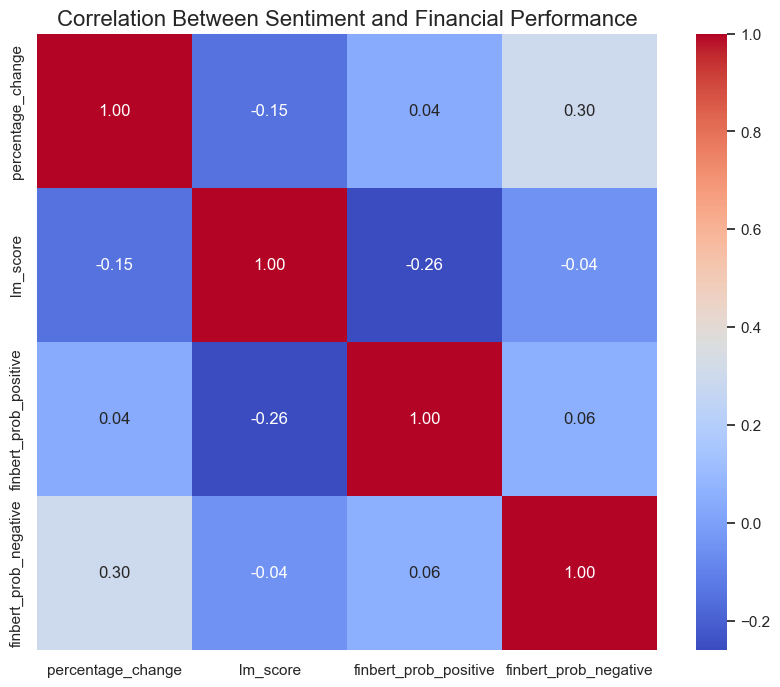

Generating Regression Scatter Plots...


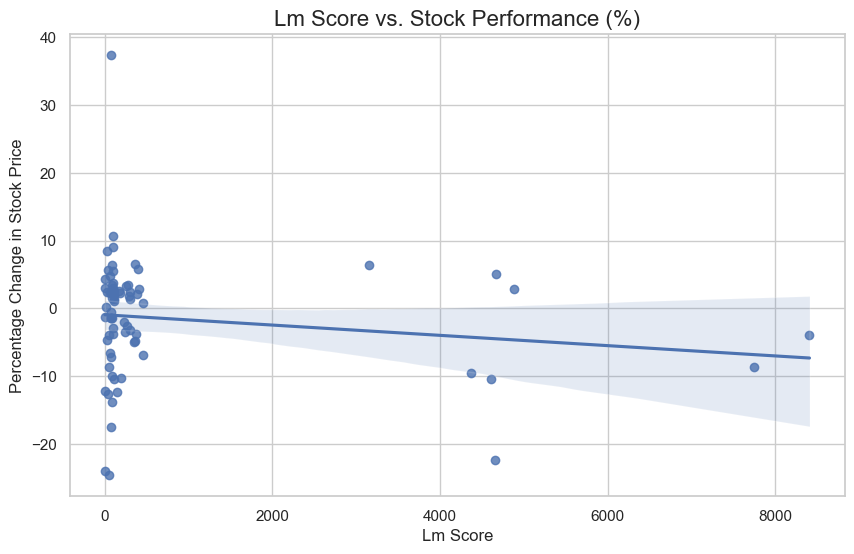

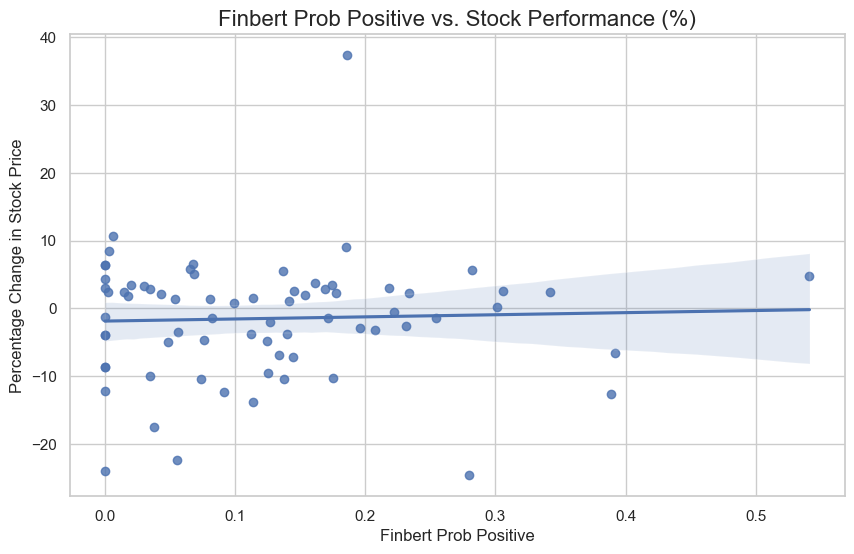

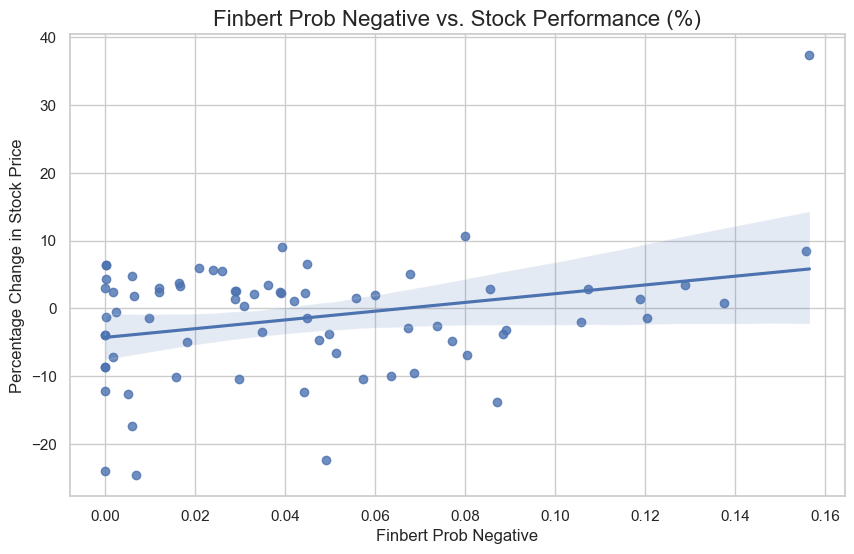

Generating Categorical Performance Bar Plots...
Skipping plot for "lm_score": required columns not found.
Skipping plot for "finbert_prob_positive": required columns not found.
Skipping plot for "finbert_prob_negative": required columns not found.
Generating Faceted Scatter Plots by Ticker...


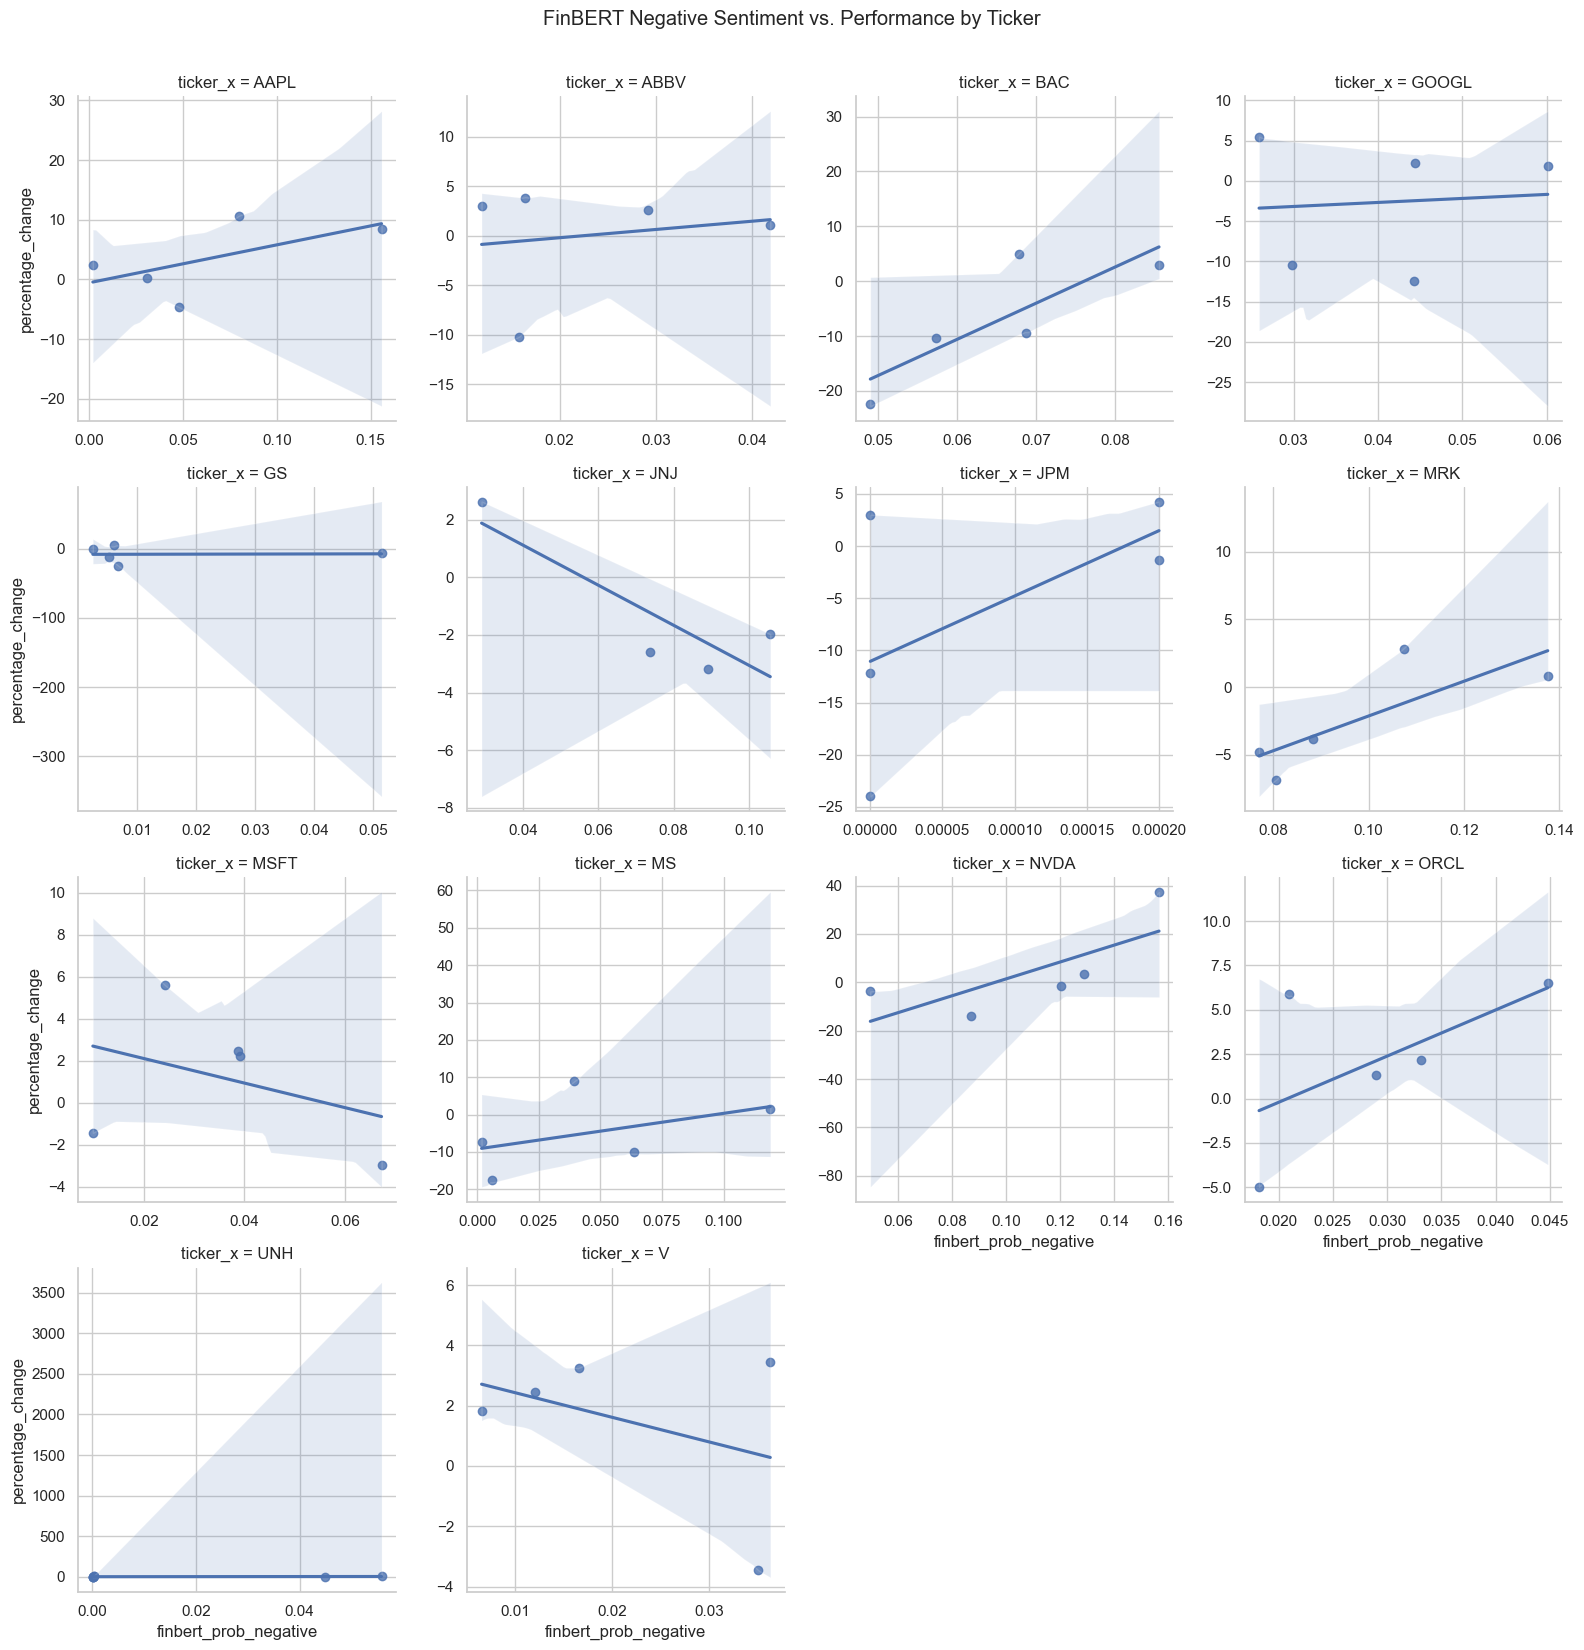

Generating Yearly Sentiment Comparison Chart...


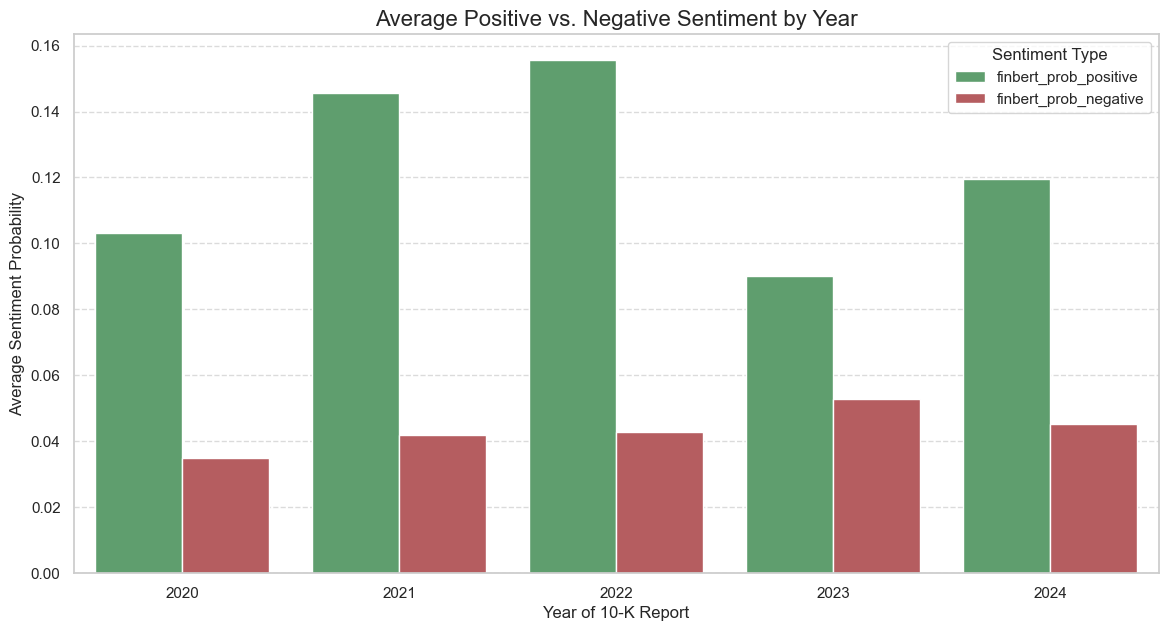

Generating Yearly Sentiment Trend Chart...


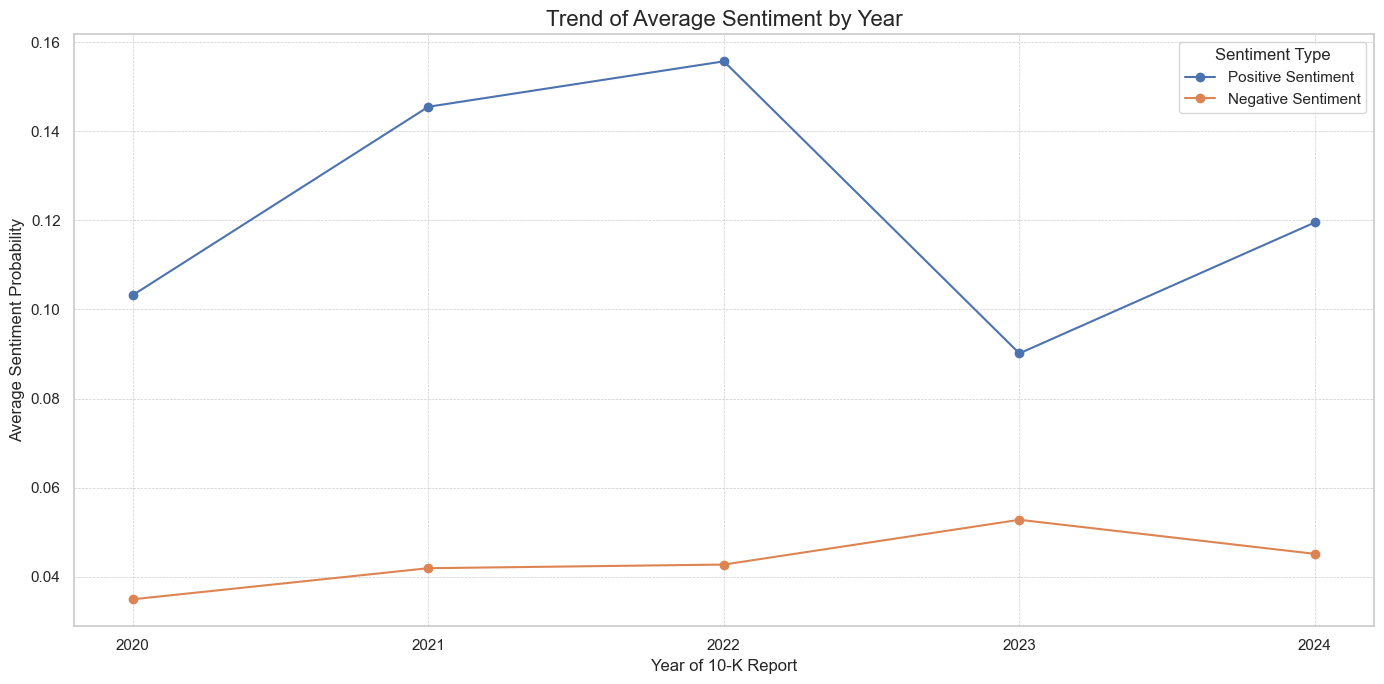

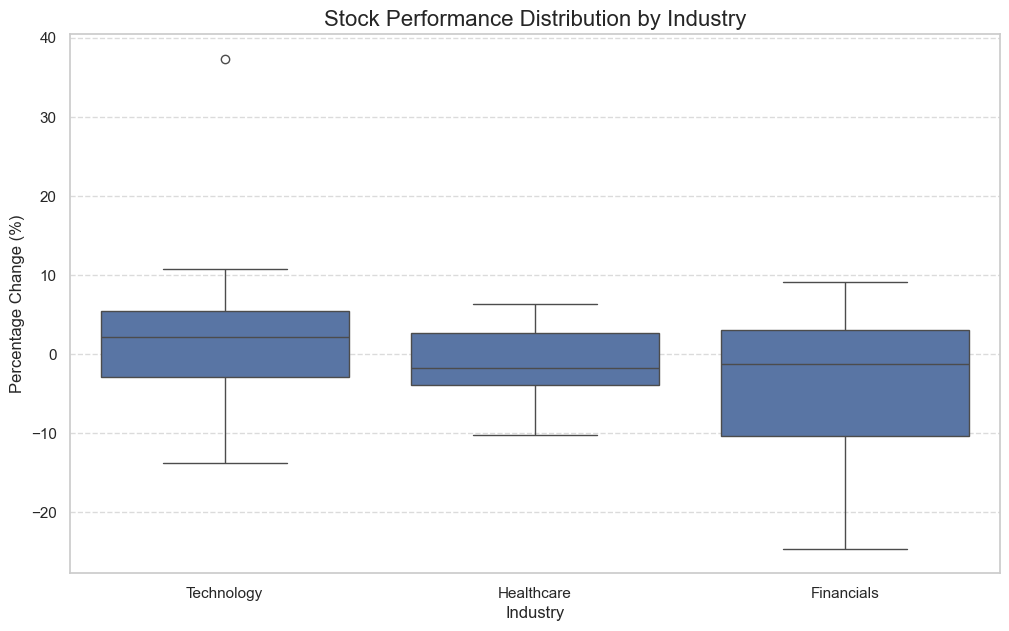

Generating Industry Performance Trend Chart...


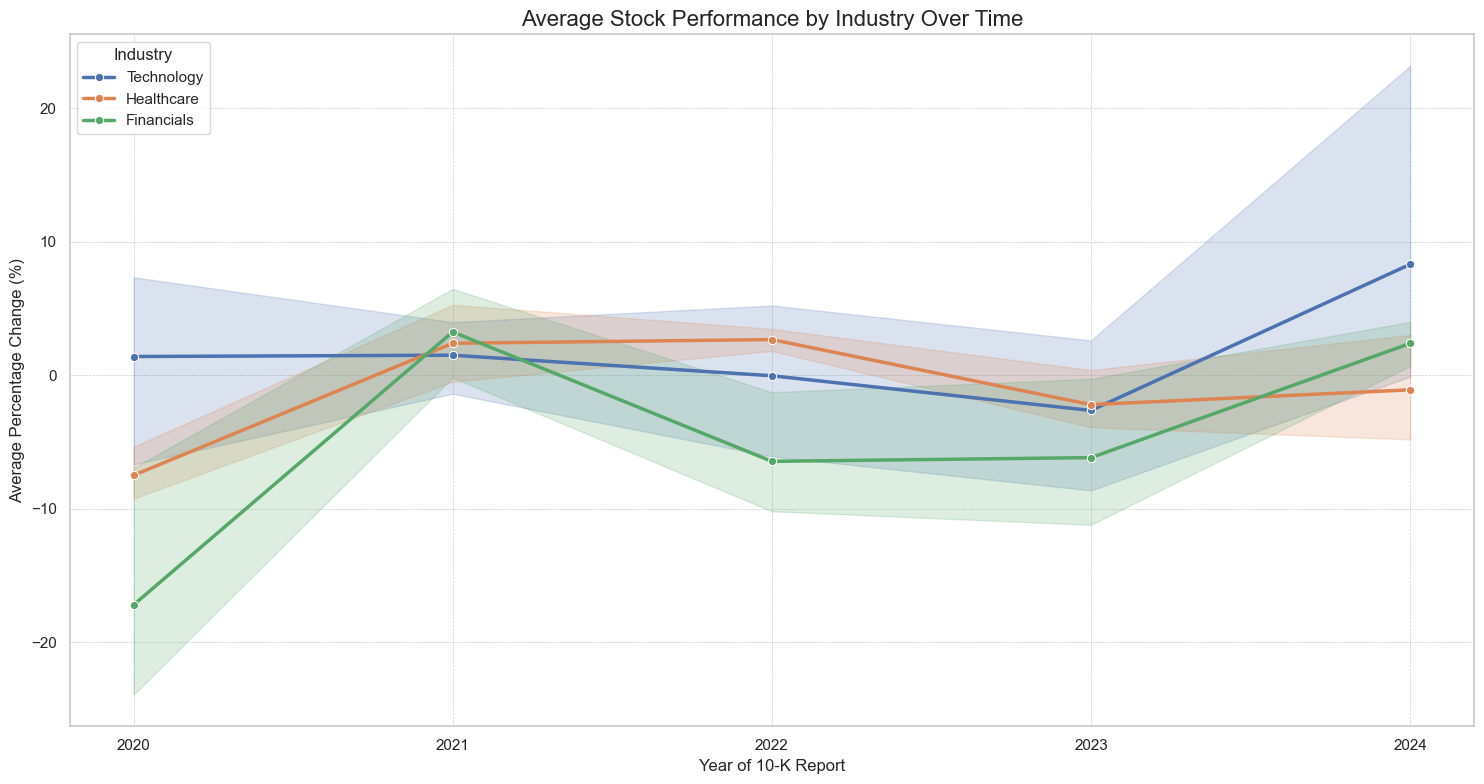

Generating Yearly Industry Sentiment vs. Performance Chart...


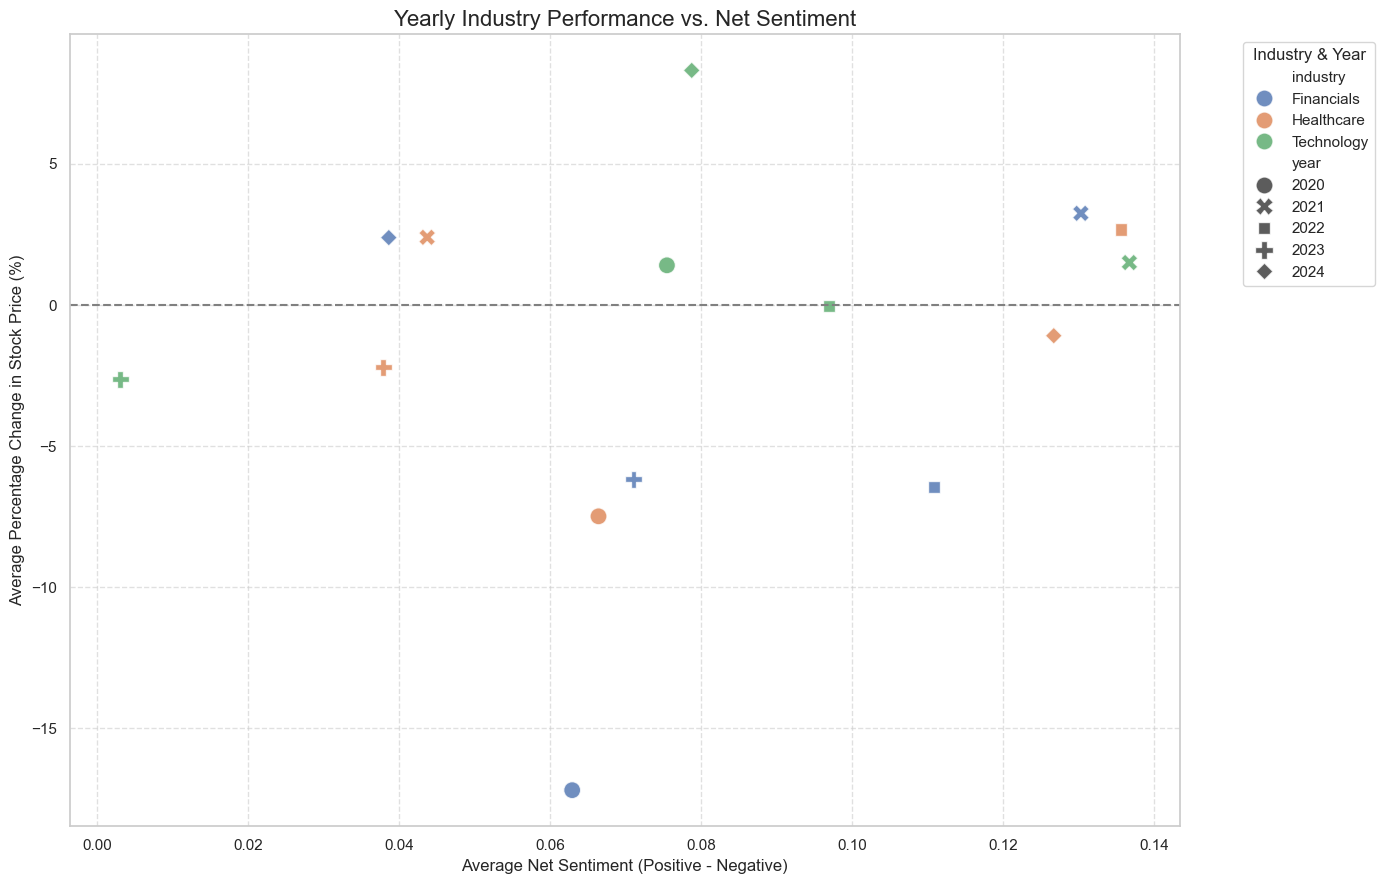

Generating Styled Summary Tables...
Average Stock Performance (%) by Industry and Year


industry,Financials,Healthcare,Technology
year,,,
2020,-17.19%,-7.49%,1.41%
2021,3.25%,2.40%,1.51%
2022,-6.44%,2.68%,-0.03%
2023,-6.16%,-2.20%,-2.63%
2024,2.39%,-1.09%,8.31%


Average Net Sentiment by Industry and Year


industry,Financials,Healthcare,Technology
year,,,
2020,0.063,0.066,0.075
2021,0.130,0.044,0.137
2022,0.111,0.136,0.097
2023,0.071,0.038,0.003
2024,0.039,0.127,0.079


Generating Industry Net Sentiment Trend Chart...


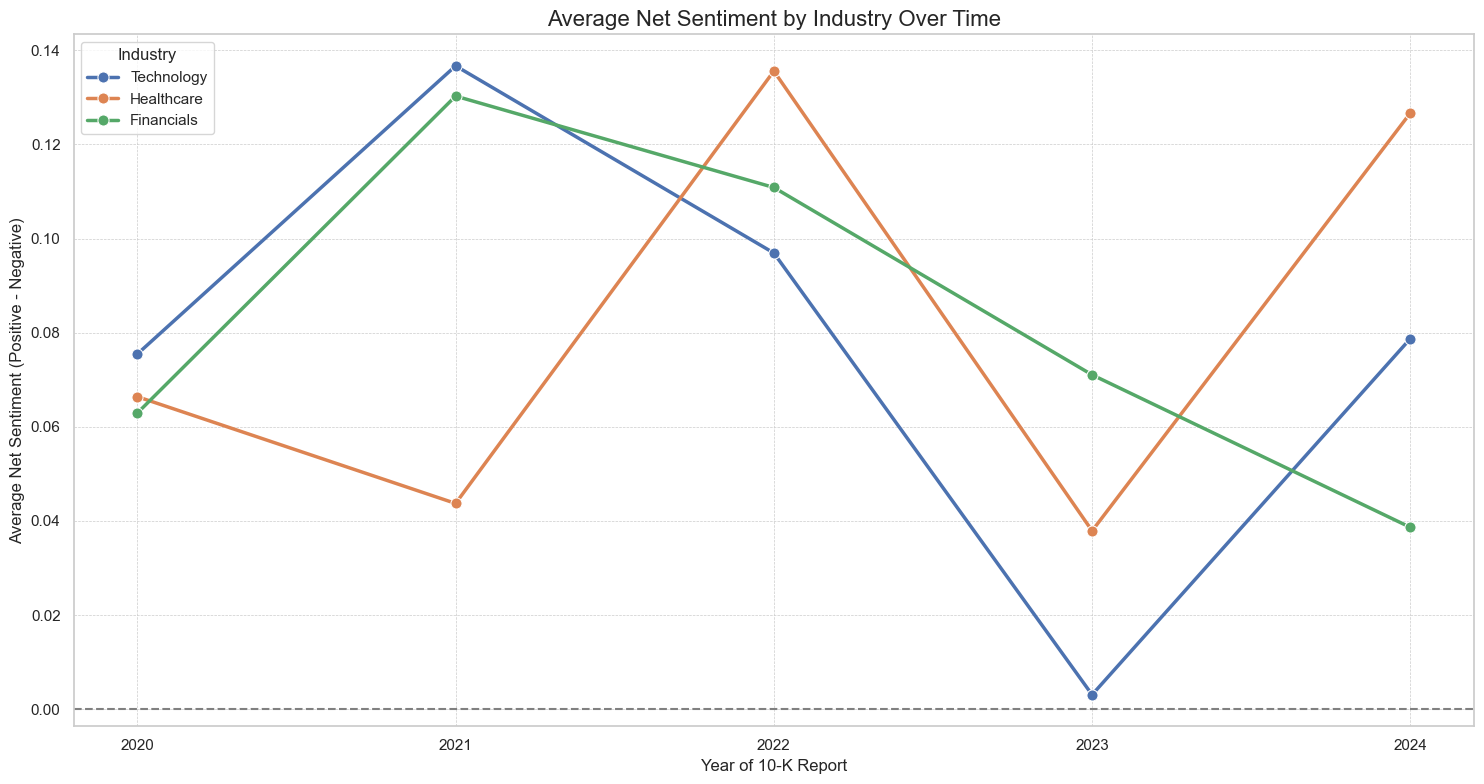


--- Analyzing Industry-Level Correlations ---

Correlation of Sentiment with Stock Performance by Industry:
                       Technology  Healthcare  Financials
lm_score                -0.018761   -0.236433   -0.080696
finbert_prob_positive    0.053498    0.140538   -0.040159
finbert_prob_negative    0.440536   -0.010482    0.145530


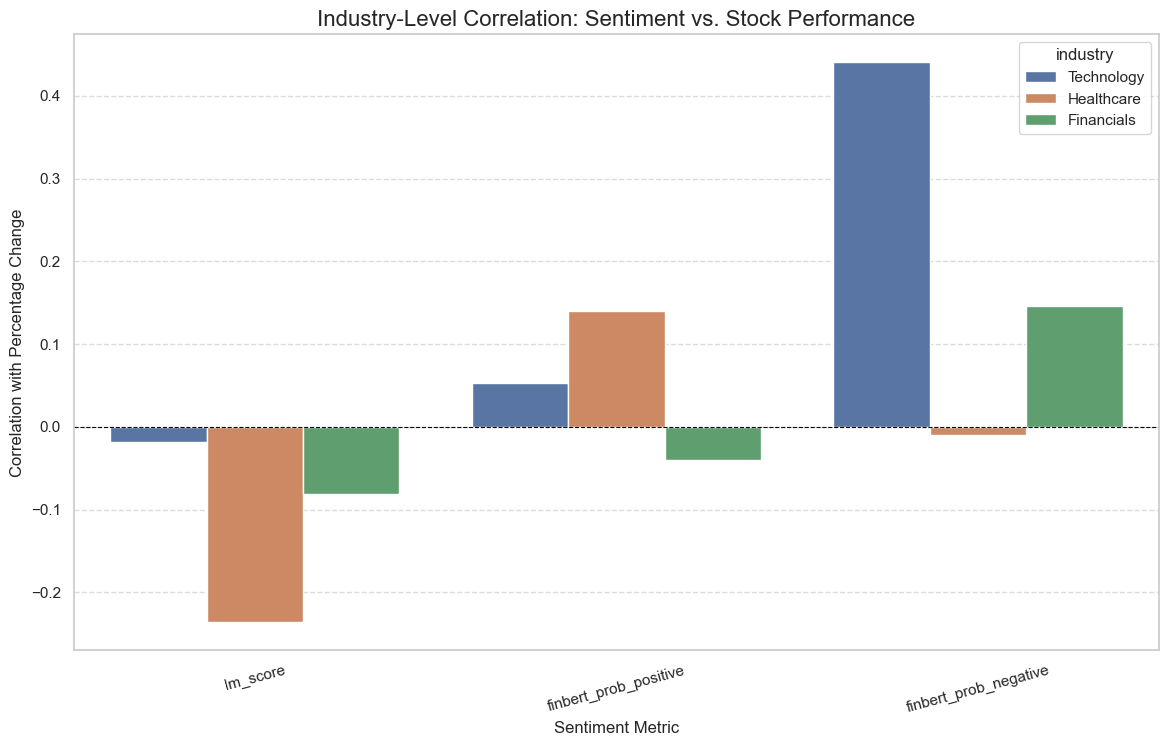


 Risk Negative Sentiment: 0.05176000000000001
Risk Positive Sentiment: 0.16899

 Overall Negative Sentiment: 0.043470833333333334
Overall Postive Sentiment: 0.12243333333333334

 Financials Negative Sentiment: 0.029467999999999998
Financials Positive Sentiment: 0.11220799999999999
All visualizations generated.


In [ ]:
def plot_correlation_heatmap(df):
    """
    Creates and displays a heatmap of the correlation between key sentiment
    and financial performance metrics.
    """
    print("Generating Correlation Heatmap...")
    correlation_cols = [
        "percentage_change",
        "lm_score",
        "finbert_prob_positive",
        "finbert_prob_negative"
    ]
    existing_cols = [col for col in correlation_cols if col in df.columns]
    if len(existing_cols) < 2:
        print("Not enough columns to generate a correlation heatmap.")
        return

    correlation_matrix = df[existing_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f"
    )
    plt.title("Correlation Between Sentiment and Financial Performance", fontsize=16)
    plt.show()

def plot_regression_scatter(df):
    """
    Creates and displays scatter plots with regression lines to show the
    relationship between each sentiment metric and stock performance.
    """
    print("Generating Regression Scatter Plots...")
    sentiment_metrics = ["lm_score", "finbert_prob_positive", "finbert_prob_negative"]
    
    for metric in sentiment_metrics:
        if metric not in df.columns:
            print(f'Skipping plot for "{metric}": column not found.')
            continue

        plt.figure(figsize=(10, 6))
        sns.regplot(data=df, x=metric, y="percentage_change")
        
        plt.title(f'{metric.replace("_", " ").title()} vs. Stock Performance (%)', fontsize=16)
        plt.xlabel(metric.replace("_", " ").title())
        plt.ylabel("Percentage Change in Stock Price")
        plt.grid(True)
        plt.show()

def plot_categorical_performance_bars(df):
    """
    Creates bar plots showing the average sentiment for stocks that
    rose versus those that fell.
    """
    print("Generating Categorical Performance Bar Plots...")
    sentiment_metrics = ["lm_score", "finbert_prob_positive", "finbert_prob_negative"]

    for metric in sentiment_metrics:
        if metric not in df.columns or "rose_y" not in df.columns:
            print(f'Skipping plot for "{metric}": required columns not found.')
            continue

        plt.figure(figsize=(8, 6))
        sns.barplot(data=df, x="rose_y", y=metric)
        
        plt.title(f'Average {metric.replace("_", " ").title()} for Stocks That Rose vs. Fell', fontsize=14)
        plt.xlabel("Stock Price Rose After Report")
        plt.ylabel(f'Average {metric.replace("_", " ").title()}')
        plt.xticks([False, True], ["Fell or Stayed Flat", "Rose"])
        plt.show()

def plot_faceted_scatter_by_ticker(df):
    """
    Creates a grid of scatter plots to show the
    sentiment-performance relationship for each individual ticker.
    """
    print("Generating Faceted Scatter Plots by Ticker...")
    if "finbert_prob_negative" not in df.columns or "ticker_x" not in df.columns:
        print('Skipping faceted plot: required "finbert_prob_positive" or "ticker_x" column not found.')
        return

    sns.lmplot(
        data=df,
        x="finbert_prob_negative",
        y="percentage_change",
        col="ticker_x",      
        col_wrap=4,      
        height=4,
        sharex=False,        
        sharey=False        
    )
    plt.suptitle("FinBERT Negative Sentiment vs. Performance by Ticker", y=1.03) 
    plt.show()

def plot_yearly_sentiment_comparison(df):
    """
    Creates a grouped bar chart to compare the average positive vs. negative
    FinBERT sentiment for each year.
    """
    print("Generating Yearly Sentiment Comparison Chart...")
    if "year" not in df.columns:
        print('DataFrame is missing the "year" column. Please add it first.')
        return

    yearly_sentiment = df.groupby("year")[["finbert_prob_positive", "finbert_prob_negative"]].mean().reset_index()

    yearly_sentiment_melted = yearly_sentiment.melt(
        id_vars="year",
        value_vars=["finbert_prob_positive", "finbert_prob_negative"],
        var_name="sentiment_type",
        value_name="average_probability"
    )

    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=yearly_sentiment_melted,
        x="year",
        y="average_probability",
        hue="sentiment_type",
        palette={"finbert_prob_positive": "g", "finbert_prob_negative": "r"} 
    )
    
    plt.title("Average Positive vs. Negative Sentiment by Year", fontsize=16)
    plt.xlabel("Year of 10-K Report")
    plt.ylabel("Average Sentiment Probability")
    plt.legend(title="Sentiment Type")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def plot_yearly_sentiment_trend(df):
    """
    Creates a line chart to show the trend of average positive and negative
    sentiment over the years.
    """
    print("Generating Yearly Sentiment Trend Chart...")
    if "year" not in df.columns:
        print('DataFrame is missing the "year" column. Please add it first.')
        return

    yearly_sentiment = df.groupby("year")[["finbert_prob_positive", "finbert_prob_negative"]].mean()

    plt.figure(figsize=(14, 7))
    plt.plot(yearly_sentiment.index, yearly_sentiment["finbert_prob_positive"], marker="o", linestyle="-", label="Positive Sentiment")
    plt.plot(yearly_sentiment.index, yearly_sentiment["finbert_prob_negative"], marker="o", linestyle="-", label="Negative Sentiment")
    
    plt.title("Trend of Average Sentiment by Year", fontsize=16)
    plt.xlabel("Year of 10-K Report")
    plt.ylabel("Average Sentiment Probability")
    plt.legend(title="Sentiment Type")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(yearly_sentiment.index)
    plt.tight_layout()
    plt.show()

def plot_performance_per_industry(df):
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df, x="industry", y="percentage_change")
    plt.title("Stock Performance Distribution by Industry", fontsize=16)
    plt.xlabel("Industry")
    plt.ylabel("Percentage Change (%)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def plot_industry_performance_trends(df):
    """
    Creates a line chart showing the trend of average stock performance
    over the years for each industry.
    """
    print("Generating Industry Performance Trend Chart...")
    if "year" not in df.columns or "industry" not in df.columns:
        print('DataFrame is missing "year" or "industry" column. Please add them first.')
        return

    plt.figure(figsize=(15, 8))
    
    sns.lineplot(
        data=df,
        x="year",
        y="percentage_change",
        hue="industry",
        marker="o",      
        linewidth=2.5
    )
    
    plt.title("Average Stock Performance by Industry Over Time", fontsize=16)
    plt.xlabel("Year of 10-K Report")
    plt.ylabel("Average Percentage Change (%)")
    plt.legend(title="Industry")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

def plot_sentiment_vs_performance_by_industry_year(df):
    """
    Creates a scatter plot showing the relationship between a a summary sentiment
    score and stock performance, aggregated by industry and year.
    """
    print("Generating Yearly Industry Sentiment vs. Performance Chart...")
    if "year" not in df.columns or "industry" not in df.columns:
        print('DataFrame is missing "year" or "industry" column. Please add them first.')
        return

    df["finbert_net_sentiment"] = df["finbert_prob_positive"] - df["finbert_prob_negative"]

    industry_yearly_data = df.groupby(["year", "industry"]).agg(
        avg_performance=("percentage_change", "mean"),
        avg_net_sentiment=("finbert_net_sentiment", "mean")
    ).reset_index()

    plt.figure(figsize=(14, 9))
    sns.scatterplot(
        data=industry_yearly_data,
        x="avg_net_sentiment",
        y="avg_performance",
        hue="industry",
        style="year",   
        s=150,       
        alpha=0.8
    )

    plt.axhline(0, color="grey", linestyle="--")
    
    plt.title("Yearly Industry Performance vs. Net Sentiment", fontsize=16)
    plt.xlabel("Average Net Sentiment (Positive - Negative)")
    plt.ylabel("Average Percentage Change in Stock Price (%)")
    plt.legend(title="Industry & Year", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def display_styled_summary_tables(df):
    """
    Creates and displays styled pivot tables for yearly industry performance
    and net sentiment.
    """
    print("Generating Styled Summary Tables...")
    if "year" not in df.columns or "industry" not in df.columns:
        print('DataFrame is missing "year" or "industry" column. Please add them first.')
        return

    df["finbert_net_sentiment"] = df["finbert_prob_positive"] - df["finbert_prob_negative"]

    industry_yearly_data = df.groupby(["year", "industry"]).agg(
        avg_performance=("percentage_change", "mean"),
        avg_net_sentiment=("finbert_net_sentiment", "mean")
    ).reset_index()

    performance_pivot = industry_yearly_data.pivot(
        index="year",
        columns="industry",
        values="avg_performance"
    )
    sentiment_pivot = industry_yearly_data.pivot(
        index="year",
        columns="industry",
        values="avg_net_sentiment"
    )
    
    print("Average Stock Performance (%) by Industry and Year")
    styled_performance = performance_pivot.style.background_gradient(cmap="RdYlGn", axis=None).format("{:.2f}%").set_caption("Average Yearly Stock Performance (%)")
    display(styled_performance) 

    print("Average Net Sentiment by Industry and Year")
    styled_sentiment = sentiment_pivot.style.background_gradient(cmap="coolwarm", axis=None).format("{:.3f}").set_caption("Average Yearly Net Sentiment (Positive - Negative)")
    display(styled_sentiment)

def plot_industry_net_sentiment_trends(df):
    """
    Creates a line chart showing the trend of average net sentiment
    (positive - negative) over the years for each industry.
    """
    print("Generating Industry Net Sentiment Trend Chart...")
    required_cols = ["year", "industry", "finbert_prob_positive", "finbert_prob_negative"]
    if not all(col in df.columns for col in required_cols):
        print(f"DataFrame is missing one or more required columns: {required_cols}. Please add them first.")
        return

    df["finbert_net_sentiment"] = df["finbert_prob_positive"] - df["finbert_prob_negative"]

    plt.figure(figsize=(15, 8))
    ax = sns.lineplot(
        data=df,
        x="year",
        y="finbert_net_sentiment",
        hue="industry",  
        marker="o",
        linewidth=2.5,
        errorbar=None,
        markersize = 8
    )

    ax.axhline(0, color="grey", linestyle="--", linewidth=1.5)

    plt.title("Average Net Sentiment by Industry Over Time", fontsize=16)
    plt.xlabel("Year of 10-K Report")
    plt.ylabel("Average Net Sentiment (Positive - Negative)")
    plt.legend(title="Industry")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

def analyze_industry_level_correlations(df):
    """
    Calculates and visualizes the correlation between sentiment and performance,
    aggregated at the industry level.
    """
    print("\n--- Analyzing Industry-Level Correlations ---")
    
    required_cols = ["industry", "percentage_change", "lm_score", "finbert_prob_positive", "finbert_prob_negative"]
    if not all(col in df.columns for col in required_cols):
        print(f"DataFrame is missing one or more required columns for this analysis. Skipping.")
        return

    unique_industries = df["industry"].unique()
    correlation_results = {}

    for industry in unique_industries:
        industry_df = df[df["industry"] == industry]
        
        if len(industry_df) < 5:
            print(f"Skipping correlation for '{industry}': not enough data points.")
            continue
            
        corr_matrix = industry_df[required_cols].corr(numeric_only=True)
        correlation_results[industry] = corr_matrix["percentage_change"]

    if not correlation_results:
        print("Could not compute any industry-level correlations.")
        return

    summary_df = pd.DataFrame(correlation_results).drop("percentage_change")
    print("\nCorrelation of Sentiment with Stock Performance by Industry:")
    print(summary_df.to_string())

    plot_df = summary_df.reset_index().melt(
        id_vars="index",
        var_name="industry",
        value_name="correlation"
    ).rename(columns={"index": "sentiment_metric"})

    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=plot_df,
        x="sentiment_metric",
        y="correlation",
        hue="industry"
    )
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.title("Industry-Level Correlation: Sentiment vs. Stock Performance", fontsize=16)
    plt.xlabel("Sentiment Metric")
    plt.ylabel("Correlation with Percentage Change")
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def show_average_sentiment():
    """Calculates the average sentiment probabilities for the Financial sector, the whole dataset,
      and the 10-Ks with the longest risk sections."""
    longest_risk_disclosures = list_top_risk_disclosures(df_with_topics, top_n=10)
    df_combined = pd.read_csv("combined_sentiment_analysis_pipeline.csv")
    df_combined["release_date"] = pd.to_datetime(df_combined["release_date"])
    df_combined["year"] = df_combined["release_date"].dt.year
    df_combined["industry"] = df_combined["ticker_x"].map(INDUSTRY_MAP)
    longest_risk_disclosures["ticker_x"] = longest_risk_disclosures["firm"]
    sent_for_top_risk = pd.merge(longest_risk_disclosures, df_combined, how = "left", on=["ticker_x", "year"])

    print(f'\n Risk Negative Sentiment: {sent_for_top_risk["finbert_prob_negative"].mean()}')
    print(f'Risk Positive Sentiment: {sent_for_top_risk["finbert_prob_positive"].mean()}')
    print(f'\n Overall Negative Sentiment: {df_combined["finbert_prob_negative"].mean()}')
    print(f'Overall Postive Sentiment: {df_combined["finbert_prob_positive"].mean()}')
    print(f'\n Financials Negative Sentiment: {df_combined[df_combined["industry"]=="Financials"]["finbert_prob_negative"].mean()}')
    print(f'Financials Positive Sentiment: {df_combined[df_combined["industry"]=="Financials"]["finbert_prob_positive"].mean()}')

def main():
    """
    Main function to load data and generate all visualizations.
    """
    df_combined = pd.read_csv("combined_sentiment_analysis_pipeline.csv")
    df_combined["release_date"] = pd.to_datetime(df_combined["release_date"])
    df_combined["year"] = df_combined["release_date"].dt.year
    df_combined["industry"] = df_combined["ticker_x"].map(INDUSTRY_MAP)

    plot_correlation_heatmap(df_combined)
    plot_regression_scatter(df_combined)
    plot_categorical_performance_bars(df_combined)
    plot_faceted_scatter_by_ticker(df_combined)
    plot_yearly_sentiment_comparison(df_combined)
    plot_yearly_sentiment_trend(df_combined)
    plot_performance_per_industry(df_combined)
    plot_industry_performance_trends(df_combined)
    plot_sentiment_vs_performance_by_industry_year(df_combined)
    display_styled_summary_tables(df_combined)
    plot_industry_net_sentiment_trends(df_combined)
    analyze_industry_level_correlations(df_combined)
    show_average_sentiment()

    print("All visualizations generated.")

if __name__ == "__main__":
    main()
